# 라이브러리 및 데이터 로딩

In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import wfdb 


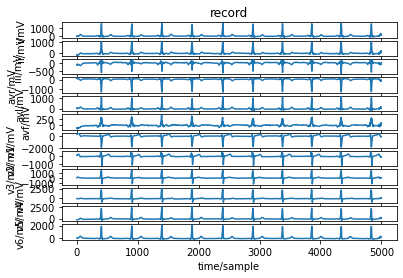

{'record_name': '19',
 'n_sig': 12,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 66',
  '<sex>: M',
  '<diagnoses>:',
  'Electric axis of the heart: left axis deviation.',
  'Incomplete left bundle branch block.',
  'Left atrial hypertrophy.',
  'Left ventricular hypertrophy.',
  'Non-specific repolarization abnormalities: posterior wall.'],
 'sig_name': ['i',
  'ii',
  'iii',
  'avr',
  'avl',
  'avf',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6'],
 'p_signal': array([[ -56.98863424, -167.0007552 , -110.00515288, ...,  -61.99617987,
         -255.00685349,   -9.99082475],
        [ -67.99204983, -149.99487213,  -81.99741404, ...,  -67.01414743,
         -255.00685349,  -20.0156319 ],
        [ -44.9994405 , -152.0087267 , -107.00043915, ...,  -52.01420139,
         -242.01378313,    0.        ],
        ...,
        [ 187.00477969,  179.99757592,   -7.00193471, ...,  140.01748195,
          

In [3]:
import wfdb
record = wfdb.rdrecord('1.0.0/19') 
wfdb.plot_wfdb(record=record, title='record') 
display(record.__dict__)

In [ ]:
# 데이터 로딩 
datas = []
for i in range(1,201):
    record = wfdb.rdrecord('1.0.0/'+str(i))
    datas.append(record)

datas[:3]

# 레이블링 수행 
Non-specific repolarization abnormalities 유무를 통해서 특정 환자의 위험성 여부를 예측하고 병원에서 검진을 권고해주기 위한 분류기를 구성

In [7]:

target = 'Non-specific repolarization abnormalities'
labels = []

for data in datas:
    s = ''.join(data.comments)
    if target in s:
        labels.append(1)
    else:
        labels.append(0)
labels[:10]

[1, 1, 0, 0, 1, 0, 0, 0, 1, 0]

# 훈련, 검증, 테스트 데이터 분리

In [14]:
from sklearn.model_selection import train_test_split
trainDatas,testDatas, trainLabels,testLabels = train_test_split(datas,labels,test_size=0.2,random_state = 42,stratify=labels)
validDatas,testDatas, validLabels, testLabels = train_test_split(testDatas,testLabels,test_size=0.5,random_state = 42,stratify=testLabels)
len(trainDatas),len(trainLabels),len(validDatas),len(validLabels),len(testDatas),len(testLabels)

(160, 160, 20, 20, 20, 20)

In [138]:
from collections import Counter
Counter(trainLabels+validLabels),Counter(testLabels)

(Counter({0: 136, 1: 44}), Counter({0: 15, 1: 5}))

# p signal 을 추출

In [15]:
def dataToMat(datas):
    mat = np.zeros(shape=(len(datas),12,5000))
    for i in range(len(datas)):
        mat[i] = datas[i].p_signal.T
    return mat
trainMat = dataToMat(trainDatas)
validMat = dataToMat(validDatas)
testMat = dataToMat(testDatas)
trainMat.shape,validMat.shape,testMat.shape

((160, 12, 5000), (20, 12, 5000), (20, 12, 5000))

# 1-dimensional Convolutional AutoEncoder 구현
Encoder는 3개의 1d convolution 3개의 ReLU unit이 Decoder에는 3개의 de-convolution과 4개의 ReLU, 1개의 convolution으로 구성

In [27]:
import torch
import torch.nn as nn



class AutoEncoderV1(nn.Module):
    def __init__(self):
        super(AutoEncoderV1,self).__init__()
        self.n_chan = [16,32,64]
        n_filter = 9
        n_stride = 5
        self.Encoder = nn.Sequential(*[
            nn.Conv1d(12,self.n_chan[0],n_filter,n_stride),
            nn.ReLU(True),
            nn.Conv1d(self.n_chan[0],self.n_chan[1],n_filter,n_stride),
            nn.ReLU(True),
            nn.Conv1d(self.n_chan[1],self.n_chan[2],n_filter,n_stride),
            nn.ReLU(True)
        ])
        
        self.Decoder = nn.Sequential(*[
            nn.ConvTranspose1d(self.n_chan[2],self.n_chan[1],n_filter,n_stride),
            nn.ReLU(True),
            nn.ConvTranspose1d(self.n_chan[1],self.n_chan[0],n_filter,n_stride),
            nn.ReLU(True),
            nn.ConvTranspose1d(self.n_chan[0],12,n_filter,n_stride,output_padding=1),
            nn.ReLU(True),
            nn.Conv1d(12,12,3,1,1),
            nn.ReLU(True)
        ])

    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

    def encode(self,x):
        batch_size = x.shape[0]
        x = self.Encoder(x).view((batch_size,-1))
        return x
        

데이터셋 클래스 구성 및 데이터 로더 구성
MSE 손실함수를 오토인코더의 재구성 오차 함수로 선택


In [46]:
class MatDataset(torch.utils.data.Dataset):
    def __init__(self,mat):
        self.mat = mat
    def __len__(self):
        return len(self.mat)
    def __getitem__(self,i):
        return self.mat[i]
trainDataset = MatDataset(trainMat)
validDataset = MatDataset(validMat)
testDataset = MatDataset(testMat)

trainLoader = torch.utils.data.DataLoader(trainDataset,batch_size=20,num_workers=4)
validLoader = torch.utils.data.DataLoader(validDataset,batch_size=20,num_workers=1)
testLoader = torch.utils.data.DataLoader(testDataset,batch_size=20,num_workers=1)

print(len(trainLoader),len(validLoader),len(testLoader))


def trainModel(model,trainLoader,optimizer,num_print=20):
    model.train()
    training_loss = 0
    training_correct = 0
    total = 0
    criterion = torch.nn.MSELoss()
    for idx,data in enumerate(trainLoader):
        data = data.float().cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,data)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    training_loss = training_loss/len(trainLoader)
    
    return training_loss


def testModel(model,testLoader,return_prediction=False):
    model.eval()
    test_loss = 0
    test_correct = 0
    total = 0
    criterion = torch.nn.MSELoss()
    with torch.no_grad():
        for idx,data in enumerate(testLoader):
            data = data.float().cuda()
            output = model(data)
            loss = criterion(output,data)
            test_loss+=loss.item()
            
    test_loss = test_loss/len(testLoader)
    return test_loss


import copy
def loop(model,trainLoader,validLoader,optimizer,epochs = 20000):
    best_loss = None
    best_model = None
    history = {}
    history['loss'] = []
    history['valid_loss'] = []
    pat_max = 100
    pat = 0
    for i in range(epochs):
        loss = trainModel(model,trainLoader,optimizer)
        
        valid_loss = testModel(model, validLoader,optimizer)
        print('epoch: %d'%(i),end=' ')
        print('train loss: ',loss,end=', '); print('valid loss: ',valid_loss)
        if best_loss is None:
            best_loss = valid_loss
            best_model = copy.deepcopy(model.state_dict())
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = copy.deepcopy(model.state_dict())
            print('patience is reset, best model is updated')
            pat = 0
            
        else:
            pat += 1
            if pat > pat_max: break
            
            
        history['loss'].append(loss)
        history['valid_loss'].append(valid_loss)
    model.load_state_dict(best_model)
    return model,best_loss,history



8 1 1


# 오토인코더 학습 및 조기 종료
오토인코더는 훈련 데이터에 대해서 학습 후 검증 데이터로 재구성 오차를 계산
재구성 오차가 100 에폭 동안 감소하지 않으면 재구성 오차 함수가 가장 적었던 최적의 모델 파라메터로 모델을 설정한 후에 훈련 종료
모델은 1258에폭을 학습한 후에 오차가 줄어들지 않아 조기 종료 됨 

In [47]:

auto1 = AutoEncoderV1().cuda()
optimizer = torch.optim.Adam(auto1.parameters(),lr=0.001)
epochs = 20000

best_auto1,best_auto1_loss, auto1_his = loop(auto1,trainLoader,validLoader,optimizer,20000)




epoch: 0 train loss:  61357.14013671875, valid loss:  61925.046875
epoch: 1 train loss:  61236.10595703125, valid loss:  61459.38671875
patience is reset, best model is updated
epoch: 2 train loss:  60359.20849609375, valid loss:  60311.51171875
patience is reset, best model is updated
epoch: 3 train loss:  58738.1357421875, valid loss:  58426.34765625
patience is reset, best model is updated
epoch: 4 train loss:  56684.7197265625, valid loss:  56722.34375
patience is reset, best model is updated
epoch: 5 train loss:  54959.503173828125, valid loss:  55822.30859375
patience is reset, best model is updated
epoch: 6 train loss:  53549.35888671875, valid loss:  55479.76171875
patience is reset, best model is updated
epoch: 7 train loss:  52399.73583984375, valid loss:  56036.45703125
epoch: 8 train loss:  52126.55419921875, valid loss:  55693.5703125
epoch: 9 train loss:  50871.518310546875, valid loss:  55188.62890625
patience is reset, best model is updated
epoch: 10 train loss:  49126.

epoch: 80 train loss:  33139.9931640625, valid loss:  32690.947265625
patience is reset, best model is updated
epoch: 81 train loss:  33072.738037109375, valid loss:  32711.130859375
epoch: 82 train loss:  33054.818359375, valid loss:  32601.326171875
patience is reset, best model is updated
epoch: 83 train loss:  32973.95556640625, valid loss:  32545.505859375
patience is reset, best model is updated
epoch: 84 train loss:  32968.904296875, valid loss:  32378.974609375
patience is reset, best model is updated
epoch: 85 train loss:  32834.718994140625, valid loss:  32305.431640625
patience is reset, best model is updated
epoch: 86 train loss:  32758.34375, valid loss:  32173.974609375
patience is reset, best model is updated
epoch: 87 train loss:  32569.701171875, valid loss:  32120.98828125
patience is reset, best model is updated
epoch: 88 train loss:  32448.698486328125, valid loss:  32061.611328125
patience is reset, best model is updated
epoch: 89 train loss:  32303.667724609375, v

epoch: 165 train loss:  30176.5, valid loss:  30438.2421875
epoch: 166 train loss:  30226.720703125, valid loss:  30164.603515625
epoch: 167 train loss:  30152.63134765625, valid loss:  30181.92578125
epoch: 168 train loss:  30198.00732421875, valid loss:  29967.0390625
patience is reset, best model is updated
epoch: 169 train loss:  30065.000732421875, valid loss:  30113.072265625
epoch: 170 train loss:  30085.610595703125, valid loss:  29996.66015625
epoch: 171 train loss:  29967.575439453125, valid loss:  30069.07421875
epoch: 172 train loss:  29985.677001953125, valid loss:  29906.265625
patience is reset, best model is updated
epoch: 173 train loss:  29897.95654296875, valid loss:  29956.359375
epoch: 174 train loss:  29918.195556640625, valid loss:  29817.220703125
patience is reset, best model is updated
epoch: 175 train loss:  29835.605712890625, valid loss:  29895.943359375
epoch: 176 train loss:  29867.0849609375, valid loss:  29823.32421875
epoch: 177 train loss:  29785.6047

epoch: 261 train loss:  28319.958740234375, valid loss:  28572.484375
epoch: 262 train loss:  28349.76513671875, valid loss:  28492.830078125
epoch: 263 train loss:  28301.201416015625, valid loss:  28603.099609375
epoch: 264 train loss:  28329.1533203125, valid loss:  28476.5546875
patience is reset, best model is updated
epoch: 265 train loss:  28287.904541015625, valid loss:  28608.005859375
epoch: 266 train loss:  28312.109375, valid loss:  28476.240234375
patience is reset, best model is updated
epoch: 267 train loss:  28267.388427734375, valid loss:  28599.837890625
epoch: 268 train loss:  28298.13525390625, valid loss:  28431.421875
patience is reset, best model is updated
epoch: 269 train loss:  28260.14794921875, valid loss:  28574.501953125
epoch: 270 train loss:  28292.3173828125, valid loss:  28425.3515625
patience is reset, best model is updated
epoch: 271 train loss:  28247.139404296875, valid loss:  28549.921875
epoch: 272 train loss:  28287.324951171875, valid loss:  28

epoch: 361 train loss:  27832.513916015625, valid loss:  28399.880859375
epoch: 362 train loss:  27897.90283203125, valid loss:  28479.3515625
epoch: 363 train loss:  27909.208740234375, valid loss:  28345.43359375
epoch: 364 train loss:  28039.55908203125, valid loss:  28110.09375
epoch: 365 train loss:  28095.181396484375, valid loss:  28015.693359375
epoch: 366 train loss:  28246.467529296875, valid loss:  28453.505859375
epoch: 367 train loss:  28186.36767578125, valid loss:  28902.546875
epoch: 368 train loss:  28272.891357421875, valid loss:  29415.322265625
epoch: 369 train loss:  28332.50634765625, valid loss:  28774.591796875
epoch: 370 train loss:  28214.029541015625, valid loss:  27985.595703125
patience is reset, best model is updated
epoch: 371 train loss:  27880.157958984375, valid loss:  28114.568359375
epoch: 372 train loss:  27829.22412109375, valid loss:  28011.6328125
epoch: 373 train loss:  27754.68505859375, valid loss:  28015.314453125
epoch: 374 train loss:  2778

epoch: 466 train loss:  27403.558837890625, valid loss:  27586.365234375
epoch: 467 train loss:  27349.786865234375, valid loss:  27725.39453125
epoch: 468 train loss:  27353.439697265625, valid loss:  27520.673828125
epoch: 469 train loss:  27301.552978515625, valid loss:  27473.09765625
patience is reset, best model is updated
epoch: 470 train loss:  27310.22607421875, valid loss:  27431.25390625
patience is reset, best model is updated
epoch: 471 train loss:  27228.037353515625, valid loss:  27465.328125
epoch: 472 train loss:  27253.164794921875, valid loss:  27570.8515625
epoch: 473 train loss:  27205.967529296875, valid loss:  27484.04296875
epoch: 474 train loss:  27238.478515625, valid loss:  27494.455078125
epoch: 475 train loss:  27200.7060546875, valid loss:  27408.36328125
patience is reset, best model is updated
epoch: 476 train loss:  27215.036865234375, valid loss:  27391.5078125
patience is reset, best model is updated
epoch: 477 train loss:  27184.72705078125, valid lo

epoch: 574 train loss:  27073.480712890625, valid loss:  27484.7265625
epoch: 575 train loss:  27061.320556640625, valid loss:  27608.255859375
epoch: 576 train loss:  27093.017333984375, valid loss:  27567.73828125
epoch: 577 train loss:  27103.1435546875, valid loss:  27484.826171875
epoch: 578 train loss:  27117.17431640625, valid loss:  27224.34765625
epoch: 579 train loss:  26998.07470703125, valid loss:  27220.1171875
epoch: 580 train loss:  26983.991943359375, valid loss:  27419.982421875
epoch: 581 train loss:  26933.05517578125, valid loss:  27325.0234375
epoch: 582 train loss:  26955.022216796875, valid loss:  27301.685546875
epoch: 583 train loss:  26927.897216796875, valid loss:  27266.94921875
epoch: 584 train loss:  26927.389404296875, valid loss:  27219.765625
epoch: 585 train loss:  26933.888427734375, valid loss:  27409.83203125
epoch: 586 train loss:  26968.064453125, valid loss:  27212.470703125
epoch: 587 train loss:  26941.87744140625, valid loss:  27265.072265625


epoch: 680 train loss:  26633.278564453125, valid loss:  26936.0078125
patience is reset, best model is updated
epoch: 681 train loss:  26624.814697265625, valid loss:  26924.978515625
patience is reset, best model is updated
epoch: 682 train loss:  26634.370849609375, valid loss:  26940.466796875
epoch: 683 train loss:  26638.2080078125, valid loss:  26954.09765625
epoch: 684 train loss:  26659.86962890625, valid loss:  26952.28515625
epoch: 685 train loss:  26664.81005859375, valid loss:  26934.626953125
epoch: 686 train loss:  26703.418212890625, valid loss:  26975.017578125
epoch: 687 train loss:  26691.58154296875, valid loss:  26952.275390625
epoch: 688 train loss:  26754.89404296875, valid loss:  27120.158203125
epoch: 689 train loss:  26723.125244140625, valid loss:  27068.125
epoch: 690 train loss:  26796.17578125, valid loss:  27256.404296875
epoch: 691 train loss:  26761.58935546875, valid loss:  27143.8984375
epoch: 692 train loss:  26820.651123046875, valid loss:  27264.74

epoch: 789 train loss:  26475.039794921875, valid loss:  26899.51171875
epoch: 790 train loss:  26493.4912109375, valid loss:  26960.705078125
epoch: 791 train loss:  26475.897216796875, valid loss:  26919.59765625
epoch: 792 train loss:  26496.208984375, valid loss:  26943.068359375
epoch: 793 train loss:  26468.37060546875, valid loss:  26879.64453125
epoch: 794 train loss:  26500.639404296875, valid loss:  26930.998046875
epoch: 795 train loss:  26464.74169921875, valid loss:  26808.732421875
epoch: 796 train loss:  26497.470947265625, valid loss:  26867.576171875
epoch: 797 train loss:  26457.524658203125, valid loss:  26771.3359375
epoch: 798 train loss:  26494.958251953125, valid loss:  26844.443359375
epoch: 799 train loss:  26455.271728515625, valid loss:  26776.060546875
epoch: 800 train loss:  26493.73291015625, valid loss:  26795.306640625
epoch: 801 train loss:  26456.475341796875, valid loss:  26769.046875
patience is reset, best model is updated
epoch: 802 train loss:  26

epoch: 900 train loss:  26322.64599609375, valid loss:  26675.390625
patience is reset, best model is updated
epoch: 901 train loss:  26317.045166015625, valid loss:  26706.98828125
epoch: 902 train loss:  26321.007568359375, valid loss:  26676.75390625
epoch: 903 train loss:  26306.3935546875, valid loss:  26731.55078125
epoch: 904 train loss:  26315.95751953125, valid loss:  26723.3203125
epoch: 905 train loss:  26307.2314453125, valid loss:  26737.943359375
epoch: 906 train loss:  26323.2529296875, valid loss:  26756.16796875
epoch: 907 train loss:  26320.358642578125, valid loss:  26808.455078125
epoch: 908 train loss:  26349.454345703125, valid loss:  26836.28125
epoch: 909 train loss:  26363.263427734375, valid loss:  26858.328125
epoch: 910 train loss:  26415.08544921875, valid loss:  26804.32421875
epoch: 911 train loss:  26395.619384765625, valid loss:  26799.775390625
epoch: 912 train loss:  26474.024169921875, valid loss:  26921.306640625
epoch: 913 train loss:  26464.605468

epoch: 1010 train loss:  26168.983642578125, valid loss:  26553.5625
epoch: 1011 train loss:  26160.87158203125, valid loss:  26615.439453125
epoch: 1012 train loss:  26169.06396484375, valid loss:  26601.7109375
epoch: 1013 train loss:  26170.94482421875, valid loss:  26695.736328125
epoch: 1014 train loss:  26182.841064453125, valid loss:  26614.60546875
epoch: 1015 train loss:  26196.842041015625, valid loss:  26667.779296875
epoch: 1016 train loss:  26208.640625, valid loss:  26652.6640625
epoch: 1017 train loss:  26231.7685546875, valid loss:  26781.0
epoch: 1018 train loss:  26237.969482421875, valid loss:  26721.1796875
epoch: 1019 train loss:  26245.0947265625, valid loss:  26809.373046875
epoch: 1020 train loss:  26261.9365234375, valid loss:  26680.20703125
epoch: 1021 train loss:  26255.222900390625, valid loss:  26794.3125
epoch: 1022 train loss:  26307.08935546875, valid loss:  26648.818359375
epoch: 1023 train loss:  26283.6494140625, valid loss:  26623.685546875
epoch: 1

epoch: 1122 train loss:  26180.69970703125, valid loss:  26686.193359375
epoch: 1123 train loss:  26158.1240234375, valid loss:  26535.365234375
epoch: 1124 train loss:  26313.80126953125, valid loss:  26617.05859375
epoch: 1125 train loss:  26682.757080078125, valid loss:  26705.390625
epoch: 1126 train loss:  27675.9931640625, valid loss:  26905.26953125
epoch: 1127 train loss:  26297.75390625, valid loss:  26572.1328125
epoch: 1128 train loss:  26259.461669921875, valid loss:  26535.6875
epoch: 1129 train loss:  26316.500732421875, valid loss:  26566.89453125
epoch: 1130 train loss:  26165.859619140625, valid loss:  26486.294921875
epoch: 1131 train loss:  26114.199951171875, valid loss:  26488.921875
epoch: 1132 train loss:  26066.216064453125, valid loss:  26435.416015625
patience is reset, best model is updated
epoch: 1133 train loss:  26048.9658203125, valid loss:  26446.80078125
epoch: 1134 train loss:  26026.4970703125, valid loss:  26460.251953125
epoch: 1135 train loss:  260

epoch: 1231 train loss:  26008.46435546875, valid loss:  26549.7421875
epoch: 1232 train loss:  26006.91748046875, valid loss:  26582.7578125
epoch: 1233 train loss:  26039.29248046875, valid loss:  26578.82421875
epoch: 1234 train loss:  26024.70263671875, valid loss:  26522.44140625
epoch: 1235 train loss:  26046.518798828125, valid loss:  26590.04296875
epoch: 1236 train loss:  26044.264892578125, valid loss:  26595.236328125
epoch: 1237 train loss:  26073.53515625, valid loss:  26588.306640625
epoch: 1238 train loss:  26051.21435546875, valid loss:  26612.244140625
epoch: 1239 train loss:  26079.94091796875, valid loss:  26670.15625
epoch: 1240 train loss:  26044.7333984375, valid loss:  26608.71875
epoch: 1241 train loss:  26066.36767578125, valid loss:  26706.80859375
epoch: 1242 train loss:  26048.1572265625, valid loss:  26654.447265625
epoch: 1243 train loss:  26073.523193359375, valid loss:  26685.435546875
epoch: 1244 train loss:  26057.285400390625, valid loss:  26639.72656

In [121]:
torch.save(auto1, './auto_encoder.pth')

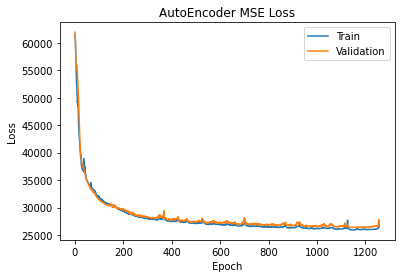

In [116]:
import matplotlib.pyplot as plt
plt.plot(auto1_his['loss'])
plt.plot(auto1_his['valid_loss'])
plt.title('AutoEncoder MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# 오토인코더를 통한 특성 추출
오토인코더가 인코딩 한 값을 추출하여 numpy 행렬로 변환 
훈련데이터, 검증데이터, 테스트 데이터 각각 변환
이후 훈련 데이터와 검증 데이터가 합해져서 최종 분류기에 교차 검증에 사용됨

In [53]:
encoded_train = []
best_auto1.eval()
for data in trainLoader:
    output = best_auto1.encode(data.float().cuda()).cpu().detach().numpy()
    encoded_train.append(output)

In [55]:
encoded_valid = []
for data in validLoader:
    output = best_auto1.encode(data.float().cuda()).cpu().detach().numpy()
    encoded_valid.append(output)
encoded_valid[0].shape

(20, 2496)

In [56]:
encoded_test = []
for data in testLoader:
    output = best_auto1.encode(data.float().cuda()).cpu().detach().numpy()
    encoded_test.append(output)
encoded_test[0].shape

(20, 2496)

In [67]:
train_val_encoedMat = np.zeros(shape=(180,2496))
encoded_train_val = encoded_train + encoded_valid
label_train_val = trainLabels + validLabels
i = 0
for mats in encoded_train_val:
    for mat in mats:
        train_val_encoedMat[i] = mat
        i += 1
train_val_encoedMat[0]

(array([1777.37646484,    0.        , 2412.89404297, ...,  690.484375  ,
        2050.79589844, 2573.90820312]),
 array([1777.37646484,    0.        , 2412.89404297, ...,  690.484375  ,
        2050.79589844, 2573.90820312]))

In [71]:
train_val_encoedMat[20],encoded_train_val[1][0]

(array([2539.00976562, 4281.24365234, 3472.55249023, ...,  410.47781372,
         171.62510681,  842.44482422]),
 array([2539.0098, 4281.2437, 3472.5525, ...,  410.4778,  171.6251,
         842.4448], dtype=float32))

In [72]:
train_val_encoedMat.shape,len(label_train_val)

((180, 2496), 180)

# Decision Tree Based AdaBoost 분류기 구성
DecisionTree 분류기를 사용하여 AdaBoost 분류기를 구성
AdaBoost를 사용하여 여러개의 약 분류기를 사용하여 이전의 분류기가 학습하기 어려운 샘플에 대해 이후의 분류기들이 점점 더 맞춰지게 학습 수행
약 분류기로 트리의 층 수를 제한시킨 DecisionTree 분류기를 수행하여 과적합을 방지
트리의 깊이, 분류기의 수, 학습률 등을 3-fold 교차 검증을 수행하여 최적의 모델을 생성함 
최적의 모델로 깊이가 1인 Decision Tree, 학습률 1.0, 분류기 갯수 150개가 선택됨. 
테스트 데이터에 대해서 85의 정확도를 보여줌.

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



params = {
    'base_estimator' : [DecisionTreeClassifier(max_depth=1),
                     DecisionTreeClassifier(max_depth=2),
                     DecisionTreeClassifier(max_depth=3)],
    'n_estimators':[50,75,100,125,150,175,200,250],
    'learning_rate':[2.0,1.5,1.0,0.75,0.5]
}


ada_clf = AdaBoostClassifier()
grid = GridSearchCV(ada_clf,params,n_jobs=8,verbose=2,cv=3)
grid.fit(train_val_encoedMat,label_train_val)

print(grid.best_params_)

out = grid.best_estimator_.predict(encoded_test[0])
from sklearn.metrics import classification_report
print(classification_report(testLabels,out,digits=4))


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   47.5s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  3.0min finished


{'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1.0, 'n_estimators': 150}
              precision    recall  f1-score   support

           0     0.8333    1.0000    0.9091        15
           1     1.0000    0.4000    0.5714         5

    accuracy                         0.8500        20
   macro avg     0.9167    0.7000    0.7403        20
weighted avg     0.8750    0.8500    0.8247        20



# 오토인코더를 사용하지 않았을 경우
Standard Scaler를 통해서 p signal을 전처리 해준 후에 Decision Tree Based AdaBoost 분류기에 적용

In [109]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scaled_train_val_encodedMat = scale.fit_transform(train_val_encoedMat)
scaled_test_encodedMat = scale.transform(encoded_test[0])


In [127]:
def dataToMat(datas):
    mat = np.zeros(shape=(len(datas),12,5000))
    for i in range(len(datas)):
        mat[i] = datas[i].p_signal.T
    return mat
trainMat = dataToMat(trainDatas)
validMat = dataToMat(validDatas)
testMat = dataToMat(testDatas)
trainMat.shape,validMat.shape,testMat.shape

((160, 12, 5000), (20, 12, 5000), (20, 12, 5000))

In [134]:
from sklearn.preprocessing import StandardScaler
trainValMat = np.concatenate((trainMat,validMat)).reshape(180,-1)
scaler = StandardScaler()
scaler.fit(trainValMat)

reshapeTrainValMat = trainValMat.reshape(180,-1)
reshapeTestMat = validMat.reshape(20,-1)
trainValMat = scaler.transform(reshapeTrainValMat)
testMat = scaler.transform(reshapeTestMat)


In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



params = {
    'base_estimator' : [DecisionTreeClassifier(max_depth=1),
                     DecisionTreeClassifier(max_depth=2),
                     DecisionTreeClassifier(max_depth=3)],
    'n_estimators':[50,75,100,125,150,175,200,250],
    'learning_rate':[2.0,1.5,1.0,0.75,0.5]
}


ada_clf = AdaBoostClassifier()
grid = GridSearchCV(ada_clf,params,n_jobs=6,verbose=2,cv=3)
grid.fit(trainValMat,label_train_val)

print(grid.best_params_)

out = grid.best_estimator_.predict(testMat.reshape(20,-1))
from sklearn.metrics import classification_report
print(classification_report(testLabels,out,digits=4))


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 32.5min
[Parallel(n_jobs=6)]: Done 360 out of 360 | elapsed: 126.0min finished


{'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.75, 'n_estimators': 250}
              precision    recall  f1-score   support

           0     0.6667    0.6667    0.6667        15
           1     0.0000    0.0000    0.0000         5

    accuracy                         0.5000        20
   macro avg     0.3333    0.3333    0.3333        20
weighted avg     0.5000    0.5000    0.5000        20



Standard Scaler를 적용하지 않은 경우

In [139]:
def dataToMat(datas):
    mat = np.zeros(shape=(len(datas),12,5000))
    for i in range(len(datas)):
        mat[i] = datas[i].p_signal.T
    return mat
trainMat = dataToMat(trainDatas)
validMat = dataToMat(validDatas)
testMat = dataToMat(testDatas)
trainMat.shape,validMat.shape,testMat.shape

((160, 12, 5000), (20, 12, 5000), (20, 12, 5000))

In [142]:

trainValMat = np.concatenate((trainMat,validMat)).reshape(180,-1)

1번 레이블을 전혀 분류하지 못함 

In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



params = {
    'base_estimator' : [DecisionTreeClassifier(max_depth=1),
                     DecisionTreeClassifier(max_depth=2),
                     DecisionTreeClassifier(max_depth=3)],
    'n_estimators':[50,75,100,125,150,175,200,250],
    'learning_rate':[2.0,1.5,1.0,0.75,0.5]
}


ada_clf = AdaBoostClassifier()
grid = GridSearchCV(ada_clf,params,n_jobs=8,verbose=2,cv=3)
grid.fit(trainValMat,label_train_val)

print(grid.best_params_)

out = grid.best_estimator_.predict(testMat.reshape(20,-1))
from sklearn.metrics import classification_report
print(classification_report(testLabels,out,digits=4))


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 24.9min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 98.8min finished


{'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1.0, 'n_estimators': 100}
              precision    recall  f1-score   support

           0     0.7368    0.9333    0.8235        15
           1     0.0000    0.0000    0.0000         5

    accuracy                         0.7000        20
   macro avg     0.3684    0.4667    0.4118        20
weighted avg     0.5526    0.7000    0.6176        20

